### Overview:
- #### This EDA aims to understand data metrics and define the project scope. It involves analyzing five tables, totaling 3 million rows and 21 columns, to define prediction scope.
- #### The goal is to help stores optimize their inventory, thereby preventing overstocking and understocking.

### Table of Contents:

1. Main Table (train.csv) EDA
2. Quito Store Table EDA
3. Oil Table EDA
4. Holidays_events Table EDAT
5. transactions Table EDA
6. Join the 5 Tables

### Data Dictionary

#### 1. sales.csv

**store_nbr**: the store at which the products are sold.

**family**: the type of product sold.

**sales**: the total sales for a product family at a particular store on a given date. Fractional values are possible since products can be sold in

fractional units (e.g., 1.5 kg of cheese, as opposed to 1 bag of chips).

**onpromotion**: the total number of items in a product family that were being promoted at a store on a given date.

#### 2. stores.csv

Store metadata, including **city, state, type, and cluster**.

cluster is a grouping of similar stores.

#### 3. oil.csv

**Daily oil price**. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

#### 4. holidays_events.csv

Holidays and Events, with metadata

NOTE: Pay special attention to the **transferred** column. A holiday that is transferred officially falls on that calendar day, but was moved to

another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for 

the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which 

means it was celebrated on 2012-10-12. 

Days that are type **Bridge** are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made 

up by the type **Work Day** which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.

**Additional** holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

#### 5. transactions.csv

**transactions**: daily store transactions

#### 6. Additional Notes

Wages in the public sector are paid every two weeks on the 15th and on the last day of the month. Supermarket sales could be affected by this.

A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which 

greatly affected supermarket sales for several weeks after the earthquake

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### 1. Main Table (train.csv) EDA

In [30]:
# Check train.csv for general information
df = pd.read_csv("train.csv")
df=df.drop(columns="id")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   date         object 
 1   store_nbr    int64  
 2   family       object 
 3   sales        float64
 4   onpromotion  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 114.5+ MB


In [31]:
df.shape

(3000888, 5)

In [32]:
df.head()

,date,store_nbr,family,sales,onpromotion
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,BABY CARE,0.0,0
2,2013-01-01,1,BEAUTY,0.0,0
3,2013-01-01,1,BEVERAGES,0.0,0
4,2013-01-01,1,BOOKS,0.0,0


In [33]:
# check for duplicated rows
df.duplicated().sum()

0

In [34]:
# check for null values
df.isnull().sum()

date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [35]:
# Add a "store_promo" column for store transaction forecasting
df["store_promo"] = df.groupby(["date", "store_nbr"])["onpromotion"].transform("sum")
df[df["onpromotion"]!=0].head()

,date,store_nbr,family,sales,onpromotion,store_promo
810784,2014-04-01,9,CLEANING,1752.00000,3,8
810789,2014-04-01,9,GROCERY I,7685.00000,5,8
812571,2014-04-02,9,GROCERY I,6481.00000,3,4
812587,2014-04-02,9,POULTRY,613.71704,1,4
814346,2014-04-03,9,BREAD/BAKERY,521.00000,1,120


Too many rows; look for ways to eliminate dateset.

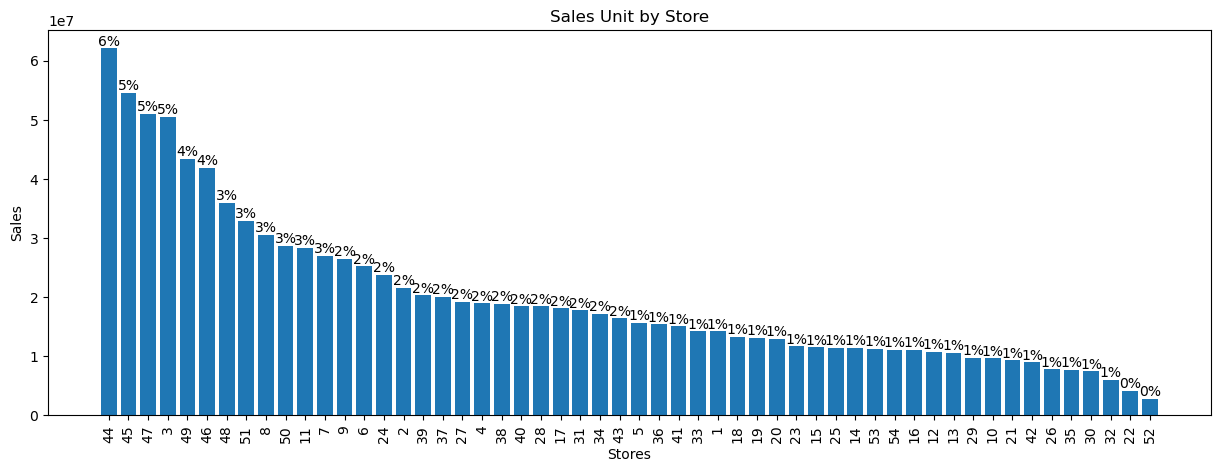

In [36]:
# Group by store_nbr, sum sales, and sort the values
df_store_sale = df.groupby("store_nbr")["sales"].sum().sort_values(ascending=False)
percts = df_store_sale / df_store_sale.sum() * 100  # Calculate each bar's percentage

# Convert the series to a DataFrame and reset the index
df_store_sale = df_store_sale.reset_index()

fig, ax = plt.subplots(figsize=(15,5))
bars = ax.bar(df_store_sale.index, df_store_sale["sales"])
ax.bar_label(bars, labels=[f"{p:.0f}%" for p in percts])

plt.xlabel("Stores")
plt.ylabel("Sales")
plt.title("Sales Unit by Store")

# Set the x-ticks and labels
plt.xticks(ticks=df_store_sale.index, labels=df_store_sale["store_nbr"], rotation=90)

plt.show()

In [37]:
# get the store numbers in Quito
df_store = pd.read_csv("stores.csv")
quito_store_list = list(df_store[df_store["city"] == "Quito"]["store_nbr"])

In [38]:
# check for stores in Quito, the capital city
quito_store_list

[1, 2, 3, 4, 6, 7, 8, 9, 10, 17, 18, 20, 44, 45, 46, 47, 48, 49]

In [39]:
# sales proportion of stores in Quito
df_quito = df_store_sale[df_store_sale["store_nbr"].isin(quito_store_list)]
round(df_quito["sales"].sum()/df_store_sale["sales"].sum() * 100,2)

51.86

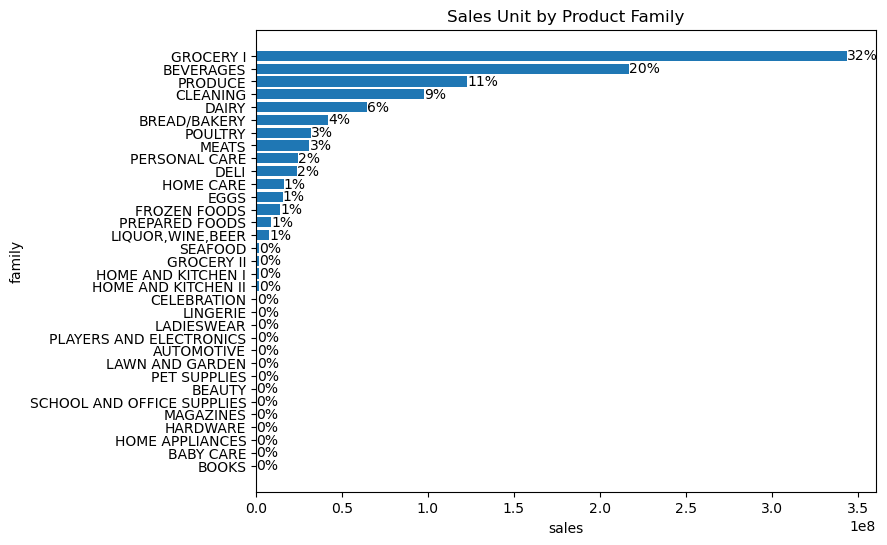

In [40]:
# plot the sales by product family
df_family = df.groupby(["family"])["sales"].sum().sort_values()
percts = df_family/df_family.sum()*100  #calculate each bar's percentage

fig, ax = plt.subplots(figsize=(8,6))
bars = ax.barh(df_family.index,df_family.values)
ax.bar_label(bars,labels=[f"{p:.0f}%" for p in percts])
plt.xlabel("sales")
plt.ylabel("family")
plt.title("Sales Unit by Product Family")
plt.show()

#### 51% of sales come from stores in Quito; the top 3 categories' sales account for 63% of the total sales. The business heavily depends on Grocery I. To reduce the number of rows from 3 million to 500,000, we can focus on predicting main product categories of stores in the capital city.

In [41]:
df_crop = df[(df["family"].isin(["GROCERY I", 'BEVERAGES','PRODUCE', 'CLEANING','DAIRY'])) & (df["store_nbr"].isin(quito_store_list))]
df_crop.info()

<class 'pandas.core.frame.DataFrame'>
Index: 151560 entries, 3 to 3000885
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   date         151560 non-null  object 
 1   store_nbr    151560 non-null  int64  
 2   family       151560 non-null  object 
 3   sales        151560 non-null  float64
 4   onpromotion  151560 non-null  int64  
 5   store_promo  151560 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 8.1+ MB


#### The cropped dataset is within the right range. Save df_crop as the main sales table for further analysis.

In [42]:
# save df_crop as sales.csv
df_crop.to_csv('sales.csv', index=False)

In [43]:
# load sales.csv
df = pd.read_csv("sales.csv")
df.head()

,date,store_nbr,family,sales,onpromotion,store_promo
0,2013-01-01,1,BEVERAGES,0.0,0,0
1,2013-01-01,1,CLEANING,0.0,0,0
2,2013-01-01,1,DAIRY,0.0,0,0
3,2013-01-01,1,GROCERY I,0.0,0,0
4,2013-01-01,1,PRODUCE,0.0,0,0


In [44]:
# check for data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151560 entries, 0 to 151559
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   date         151560 non-null  object 
 1   store_nbr    151560 non-null  int64  
 2   family       151560 non-null  object 
 3   sales        151560 non-null  float64
 4   onpromotion  151560 non-null  int64  
 5   store_promo  151560 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 6.9+ MB


In [45]:
# convert date to datetime
df["date"] = pd.to_datetime(df["date"])  # Ensure the date column is in datetime format
df.describe()

,date,store_nbr,sales,onpromotion,store_promo
count,151560,151560.000000,151560.000000,151560.000000,151560.000000
mean,2015-04-24 08:27:04.703087872,21.333333,2867.517587,13.155655,97.814760
min,2013-01-01 00:00:00,1.000000,0.000000,0.000000,0.000000
25%,2014-02-26 18:00:00,6.000000,841.000000,0.000000,0.000000
50%,2015-04-24 12:00:00,13.500000,1893.000000,1.000000,30.000000
75%,2016-06-19 06:00:00,45.000000,3837.000000,12.000000,182.000000
max,2017-08-15 00:00:00,49.000000,124717.000000,252.000000,727.000000
std,NaN,18.517320,3058.180409,29.823250,123.646587


In [46]:
# check for product families
df["family"].unique()

array(['BEVERAGES', 'CLEANING', 'DAIRY', 'GROCERY I', 'PRODUCE'],
      dtype=object)

In [47]:
# check for the number of stores
df["store_nbr"].nunique()

18

#### In the cropped dataset, there are no null values. The data has 151,560 rows and 5 columns. The target column is "sales". 

#### Data are from Jan 2013 to Aug 2017. The data contains 5 product categories in 18 stores. 

#### Project objective: predict sales units of 5 categories across 18 stores on certain dates.

### Checking for trends

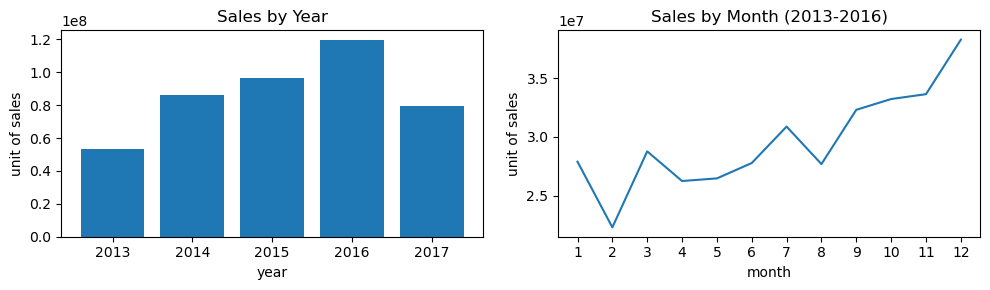

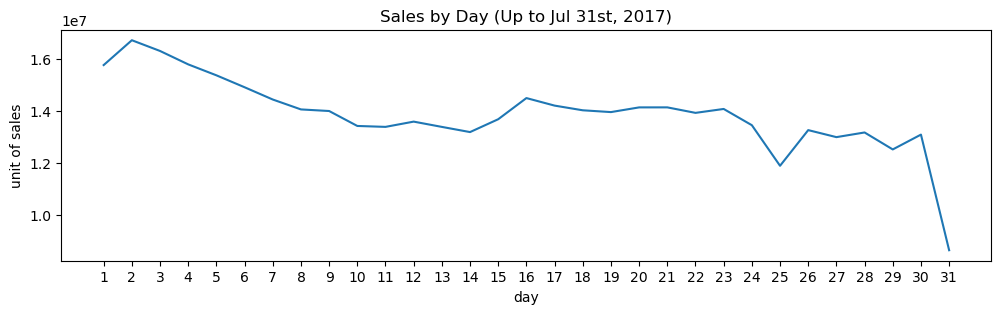

In [48]:
# Take out the incomplete data for plotting
df2 = df[df["date"].dt.year<2017]
df3 = df[df["date"]<'2017-08-01']

plt.figure(figsize=(10,3))
# plot based on years
plt.subplot(1,2,1)
year_sales=df.groupby(df["date"].dt.year)["sales"].sum()
plt.bar(year_sales.index,height=year_sales.values)
plt.xlabel("year")
plt.ylabel("unit of sales")
plt.title("Sales by Year")

# plot based on month
plt.subplot(1,2,2)
month_sales=df2.groupby(df["date"].dt.month)["sales"].sum()
plt.plot(month_sales.index, month_sales.values)
plt.xlabel("month")
plt.ylabel("unit of sales")
plt.title("Sales by Month (2013-2016)")
plt.xticks(month_sales.index)
plt.tight_layout()
plt.show()

# plot based on day
plt.figure(figsize=(12,3))
day_sales=df3.groupby(df["date"].dt.day)["sales"].sum()
plt.plot(day_sales.index, day_sales.values)
plt.xlabel("day")
plt.ylabel("unit of sales")
plt.title("Sales by Day (Up to Jul 31st, 2017)")
plt.xticks(day_sales.index)
plt.show()

#### - From 2013 to 2016, sales increased steadily. The lower sales in 2017 are due to incomplete dates of the dataset. 

#### - Overall, sales increase month by month, peaking in December. March, July, and December show high month-over-month growth.

#### - Sales decrease steadily during the first 14 days, with an increase on day 15, then remain stable until day 25 before witnessing a significant drop. Day 31 has the lowest sales.

#### Let's take a look at the promotion trends.

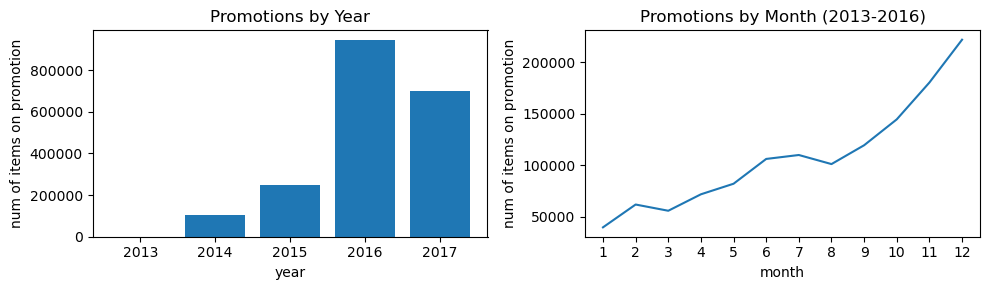

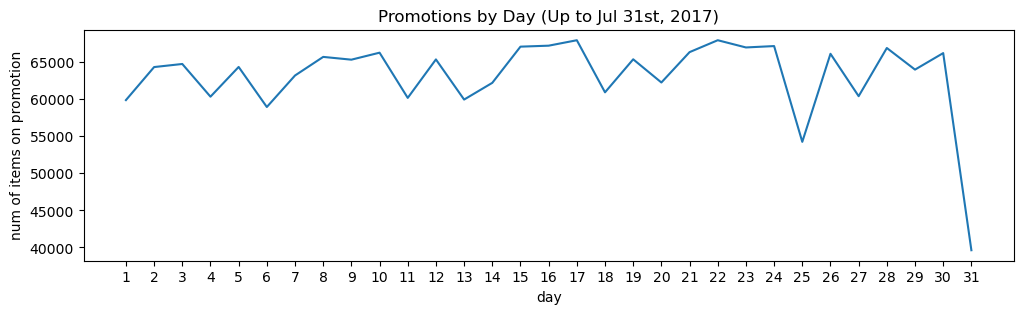

In [49]:
# Take out the incomplete data for plotting
df2 = df[df["date"].dt.year<2017]
df3 = df[df["date"]<'2017-08-01']

plt.figure(figsize=(10,3))
# plot based on years
plt.subplot(1,2,1)
year_promo=df.groupby(df["date"].dt.year)["onpromotion"].sum()
plt.bar(year_promo.index,height=year_promo.values)
plt.xlabel("year")
plt.ylabel("num of items on promotion")
plt.title("Promotions by Year")

# plot based on month
plt.subplot(1,2,2)
month_promo=df2.groupby(df["date"].dt.month)["onpromotion"].sum()
plt.plot(month_promo.index, month_promo.values)
plt.xlabel("month")
plt.ylabel("num of items on promotion")
plt.title("Promotions by Month (2013-2016)")
plt.xticks(month_promo.index)
plt.tight_layout()
plt.show()

# plot based on day
plt.figure(figsize=(12,3))
day_promo=df3.groupby(df["date"].dt.day)["onpromotion"].sum()
plt.plot(day_promo.index, day_promo.values)
plt.xlabel("day")
plt.ylabel("num of items on promotion")
plt.title("Promotions by Day (Up to Jul 31st, 2017)")
plt.xticks(day_promo.index)
plt.show()

#### - Promotions follow similar monthly trends as sales. However, the daily trends of promotions and sales vary greatly. Compared to previous years, 2016 saw a significant increase in products on promotion.

### 2. Quito Store Table EDA

In [50]:
# check for store info
df_store = pd.read_csv("stores.csv")
df_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [51]:
# check for duplicated rows
df_store.duplicated().sum()

0

In [52]:
# check for null
df_store.isnull().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

In [53]:
df_store.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


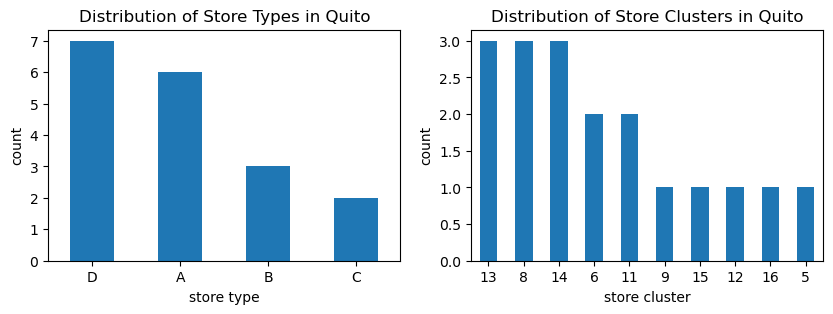

In [54]:
df_store_quito = df_store[df_store["city"] == "Quito"]
cols=["type","cluster"]
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
df_store_quito["type"].value_counts().plot(kind="bar", rot=0)
plt.xlabel("store type")
plt.ylabel("count")
plt.title("Distribution of Store Types in Quito")

plt.subplot(1,2,2)
df_store_quito["cluster"].value_counts().plot(kind="bar", rot=0)
plt.xlabel("store cluster")
plt.ylabel("count")
plt.title("Distribution of Store Clusters in Quito")

plt.show()

#### - Of the 18 stores in Quito 7 are type D, 6 type A, 3 type B and 2 type C. They belong to 10 clusters. The clustering method is not clear. For now, let's keep the column for baseline modeling and decide later.

#### The types of stores are in natual order, so we can convert the column to sequential numbers.

In [55]:
df_store_quito.reset_index(drop=1)

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,6,Quito,Pichincha,D,13
5,7,Quito,Pichincha,D,8
6,8,Quito,Pichincha,D,8
7,9,Quito,Pichincha,B,6
8,10,Quito,Pichincha,C,15
9,17,Quito,Pichincha,C,12


In [56]:
df_store_quito["type"].unique()

array(['D', 'B', 'C', 'A'], dtype=object)

In [57]:
# save the final data to a new file
df_store_quito.to_csv("stores_quito.csv", index=False)

In [58]:
# sanity check
df_store_quito = pd.read_csv("stores_quito.csv")
df_store_quito.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  18 non-null     int64 
 1   city       18 non-null     object
 2   state      18 non-null     object
 3   type       18 non-null     object
 4   cluster    18 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 852.0+ bytes


### 3. Oil Table EDA

#### Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.

In [59]:
# check for data types
df_oil = pd.read_csv("oil.csv")
df_oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


In [60]:
# convert date to datetime
df_oil["date"] = pd.to_datetime(df_oil["date"])
# sanity check
df_oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


In [61]:
# check for null
df_oil.isnull().sum()

date           0
dcoilwtico    43
dtype: int64

#### To fill the 43 null values, let's see if the nulls are consecutive.

In [62]:
# create a table of null values
df_oil_null = df_oil[df_oil["dcoilwtico"].isnull()]

In [63]:
# check for the day intervals between null values
df_oil_null["day_interval"] = df_oil_null["date"].shift(-1) - df_oil_null["date"]
df_oil_null["day_interval"].sort_values()

C:\Users\erinb\AppData\Local\Temp\ipykernel_18292\1820170812.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_oil_null["day_interval"] = df_oil_null["date"].shift(-1) - df_oil_null["date"]


1174    1 days
1039    7 days
778     7 days
517     7 days
256     7 days
1044   14 days
783    17 days
522    18 days
261    19 days
0      20 days
237    27 days
274    28 days
14     28 days
794    28 days
534    28 days
497    28 days
757    29 days
1017   32 days
1054   35 days
1149   35 days
889    35 days
104    38 days
338    38 days
814    39 days
34     39 days
624    39 days
364    39 days
1118   45 days
554    46 days
588    52 days
1079   53 days
393    59 days
63     59 days
294    60 days
132    60 days
914    63 days
843    66 days
653    66 days
699    80 days
959    80 days
434    87 days
174    87 days
1175       NaT
Name: day_interval, dtype: timedelta64[ns]

#### There are only two null values that are consecutive; we can use the forward filling to fill the null values.

In [64]:
# backward fill the null values
df_oil["dcoilwtico"] = df_oil["dcoilwtico"].bfill()

In [65]:
# sanity check
df_oil.isnull().sum()

date          0
dcoilwtico    0
dtype: int64

In [66]:
# check for duplicates
df_oil.duplicated().sum()

0

In [67]:
# save the data
df_oil.to_csv('oil2.csv', index=False)

In [68]:
# sanity check
df_oil2 = pd.read_csv('oil2.csv')
df_oil2.head()

,date,dcoilwtico
0,2013-01-01,93.14
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


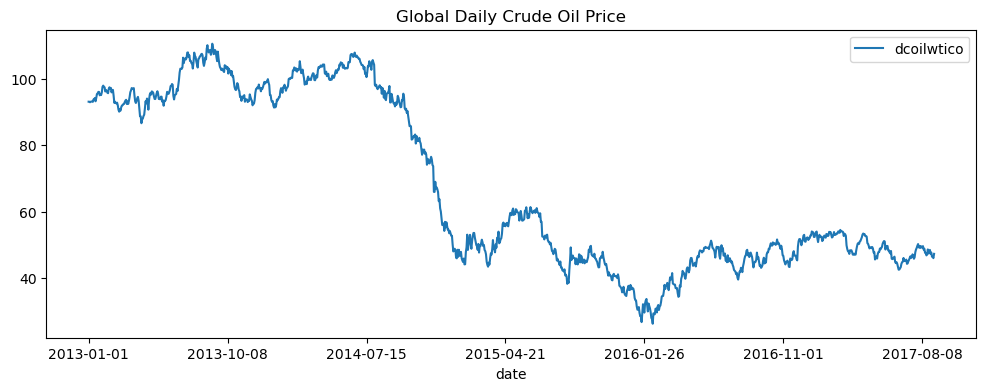

In [69]:
df_oil2.plot(x="date",y="dcoilwtico",kind="line", figsize=(12,4))
plt.title("Global Daily Crude Oil Price")
plt.show()

#### Daily crude oil prices remained stable until July 2014, then plummeted and have stayed low since. For Ecuador, a major oil exporter, this has meant reduced national revenue and weakened economy, significantly affecting consumers' purchasing power.

### 4. Holidays_events Table EDA

In [70]:
# check for type
df_ho = pd.read_csv("holidays_events.csv")
df_ho.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


In [71]:
# change date to datetime
df_ho["date"] = pd.to_datetime(df_ho["date"])
# sanity check
df_ho.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


In [72]:
# check for null
df_ho.isnull().sum()

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

In [73]:
# check for duplicates
df_ho.duplicated().sum()

0

In [74]:
# check for different kinds of holidays and events
cols=[col for col in df_ho.columns if (col != "date" and col != "description")]
cols
for col in cols:
    
    print(df_ho[col].value_counts())
    print("--------------------------")

type
Holiday       221
Event          56
Additional     51
Transfer       12
Bridge          5
Work Day        5
Name: count, dtype: int64
--------------------------
locale
National    174
Local       152
Regional     24
Name: count, dtype: int64
--------------------------
locale_name
Ecuador                           174
Quito                              13
Riobamba                           12
Guaranda                           12
Latacunga                          12
Ambato                             12
Guayaquil                          11
Cuenca                              7
Ibarra                              7
Salinas                             6
Loja                                6
Santa Elena                         6
Santo Domingo de los Tsachilas      6
Quevedo                             6
Manta                               6
Esmeraldas                          6
Cotopaxi                            6
El Carmen                           6
Santo Domingo                 

#### We need to screen the holidays celebrated in our target city Quito, which include national, regional(maybe) and local holidays. 

In [75]:
# check for national holidays
df_ho[df_ho["locale"]=="National"].head(3)

,date,type,locale,locale_name,description,transferred
14,2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False
19,2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
20,2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False


In [76]:
# check for regional holidays
df_ho[df_ho["locale"]=="Regional"]["description"].unique()

array(['Provincializacion de Cotopaxi', 'Provincializacion de Imbabura',
       'Provincializacion de Santo Domingo',
       'Provincializacion Santa Elena'], dtype=object)

#### The regional holidays are celebrated in the provinces of Cotopaxi, Imbabura, Santo Domingo, and Santa Elena; thus they are not related to our goal of analysis.

In [77]:
# check for Quito local holidays and events
df_ho[df_ho["locale_name"]=="Quito"]

,date,type,locale,locale_name,description,transferred
28,2012-12-05,Additional,Local,Quito,Fundacion de Quito-1,False
29,2012-12-06,Holiday,Local,Quito,Fundacion de Quito,False
81,2013-12-05,Additional,Local,Quito,Fundacion de Quito-1,False
82,2013-12-06,Holiday,Local,Quito,Fundacion de Quito,False
146,2014-12-05,Additional,Local,Quito,Fundacion de Quito-1,False
147,2014-12-06,Holiday,Local,Quito,Fundacion de Quito,False
200,2015-12-05,Additional,Local,Quito,Fundacion de Quito-1,False
201,2015-12-06,Holiday,Local,Quito,Fundacion de Quito,False
286,2016-12-05,Additional,Local,Quito,Fundacion de Quito-1,False
287,2016-12-06,Holiday,Local,Quito,Fundacion de Quito,False


#### Select relevant festivals and events for Quito

In [78]:
df_ho_qui = df_ho[df_ho["locale_name"].isin(["Ecuador", "Quito"])]
# sanity check
df_ho_qui.info()

<class 'pandas.core.frame.DataFrame'>
Index: 187 entries, 14 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         187 non-null    datetime64[ns]
 1   type         187 non-null    object        
 2   locale       187 non-null    object        
 3   locale_name  187 non-null    object        
 4   description  187 non-null    object        
 5   transferred  187 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 8.9+ KB


#### As explained in the data dictionary, a transferred day is more like a normal day than a holiday. We need to treat those days as normal days. So we can drop the rows that are transfered holidays.

In [79]:
# drop the transfered holidays and treat them as normal days
df_ho_qui2 = df_ho_qui[df_ho_qui["transferred"] == False]

In [80]:
df_ho_qui2["type"].value_counts()

type
Holiday       57
Event         56
Additional    46
Transfer       9
Bridge         5
Work Day       5
Name: count, dtype: int64

#### To understand what events are and how they are affecting store sales, we need to dive deep into the events.

In [81]:
df_qui_event = df_ho_qui2[df_ho_qui2["type"]=="Event"]
df_qui_event["description"].value_counts()

description
Dia de la Madre                                    5
Mundial de futbol Brasil: Octavos de Final         4
Black Friday                                       3
Cyber Monday                                       3
Mundial de futbol Brasil: Cuartos de Final         2
Mundial de futbol Brasil: Semifinales              2
Terremoto Manabi+21                                1
Terremoto Manabi+14                                1
Terremoto Manabi+15                                1
Terremoto Manabi+16                                1
Terremoto Manabi+17                                1
Terremoto Manabi+18                                1
Terremoto Manabi+19                                1
Terremoto Manabi+20                                1
Terremoto Manabi+24                                1
Terremoto Manabi+22                                1
Terremoto Manabi+23                                1
Terremoto Manabi+12                                1
Terremoto Manabi+25               

#### To better understand the description, let's translate the column into English.

In [82]:
# pip install googletrans==4.0.0-rc1

In [83]:
from googletrans import Translator
# Function to translate text
def translate_text(text):
    translator = Translator()
    translation = translator.translate(text, src='es', dest='en')
    return translation.text

In [84]:
# translate the "description" column
# df_ho_qui2['description_eng'] = df_ho_qui2['description'].apply(translate_text)

In [85]:
# sanity check
# df_ho_qui2.head()

In [86]:
# drop the spanish description and save the Quito relevant holidays and events
# drop "transferred" column since all transferred have been treated as normal days
# df_ho_qui3 = df_ho_qui2.drop(columns=["description","transferred"])
# save to a seperate file, 
# df_ho_qui3.to_csv("holidays_quito.csv", index=False)

In [87]:
# check the new holiday dataset
df_ho_qui = pd.read_csv("holidays_quito.csv")
df_ho_qui.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   date             178 non-null    object
 1   type             178 non-null    object
 2   locale           178 non-null    object
 3   description_eng  178 non-null    object
dtypes: object(4)
memory usage: 5.7+ KB


#### locale and locale_name contain the same message, we can drop local_name

In [88]:
df_ho_qui["locale"].value_counts()

locale
National    166
Local        12
Name: count, dtype: int64

In [89]:
# df_ho_qui["locale_name"].value_counts()

In [90]:
# drop locale_name
# df_ho_qui=df_ho_qui.drop(columns="locale_name")
# change date to datetime
df_ho_qui["date"] = pd.to_datetime(df_ho_qui["date"])
# sanity check
df_ho_qui.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             178 non-null    datetime64[ns]
 1   type             178 non-null    object        
 2   locale           178 non-null    object        
 3   description_eng  178 non-null    object        
dtypes: datetime64[ns](1), object(3)
memory usage: 5.7+ KB


In [91]:
# update the Quito holiday dataset
# df_ho_qui.to_csv("holidays_quito.csv", index=False)

#### Based on the additional information provided in the dictionary, we know that we should include a "payday" column and an "earthquake" column. From previous analyses, we know that paydays haven't been included in the holiday and event dataset. Let's confirm if earthquake days have been included. As for the "payday" column, we can add it once we join all our datasets together, as the sales dataset contains all the dates needed for the project.

In [92]:
# check for the earthquake
df_ho = pd.read_csv("holidays_quito.csv")
df_ho[df_ho["date"].isin(["2016-04-16","2016-04-17","2016-04-18","2016-04-19"])]

,date,type,locale,description_eng
106,2016-04-16,Event,National,Manabi earthquake
107,2016-04-17,Event,National,Manabi+1 earthquake
108,2016-04-18,Event,National,Manabi+2 earthquake
109,2016-04-19,Event,National,Manabi+3 earthquake


#### The earthquake has been included in the holiday dataset. 

#### Action: Add payday once all datasets are joined.

### 5. Transactions Table EDA

In [93]:
# check general info
df_tran = pd.read_csv("transactions.csv")
df_tran.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB


In [94]:
# check for duplicates
df_tran.duplicated().sum()

0

In [95]:
# check for null
df_tran.isnull().sum()

date            0
store_nbr       0
transactions    0
dtype: int64

In [96]:
# change date to datetime
df_tran["date"]=pd.to_datetime(df_tran["date"])
# sanity check
df_tran.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB


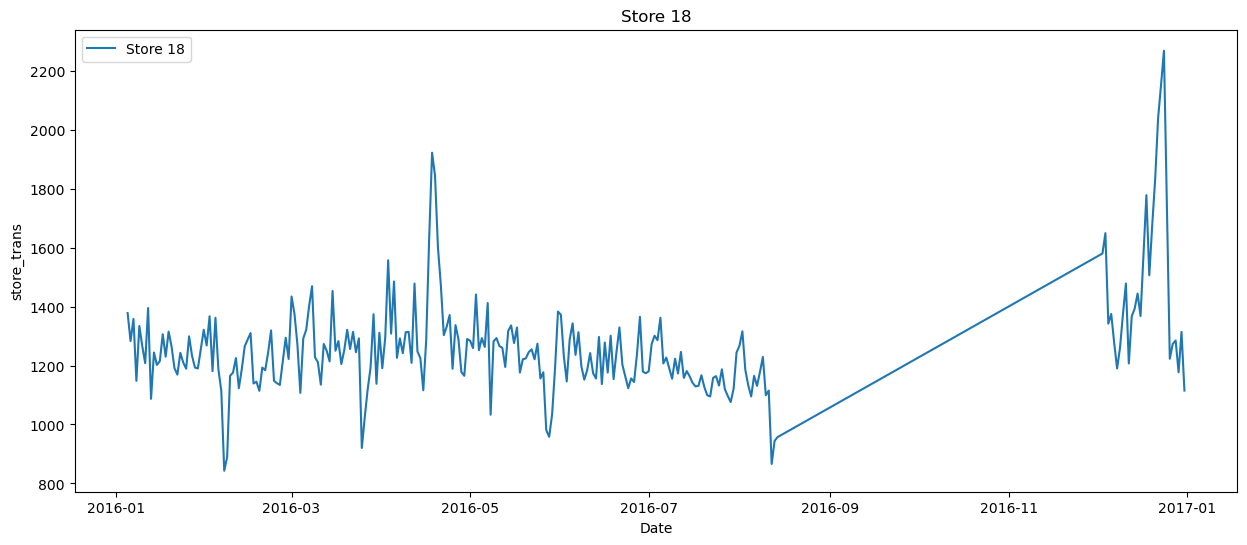

In [97]:
# Visualizing the missing data of each store
plt.figure(figsize=(15, 6))  # Adjusting figure size for better visualization
store_data = df_tran.set_index("date")
store_data = store_data[(store_data["store_nbr"] == 18) & (store_data.index.year == 2016)]
plt.plot(store_data.index, store_data["transactions"], label='Store 18')
plt.title('Store 18')
plt.xlabel('Date')
plt.ylabel('store_trans')
plt.legend()
plt.show()

In [98]:
# Additional filter for the month of September (if needed)
month_data = store_data[store_data.index.month == 12]

month_data

,store_nbr,transactions
date,,
2016-12-03,18,1580
2016-12-04,18,1649
2016-12-05,18,1342
2016-12-06,18,1375
2016-12-07,18,1277
2016-12-08,18,1190
2016-12-09,18,1261
2016-12-10,18,1374
2016-12-11,18,1478


In [99]:
# select stores in Quito
df_tran_qui = df_tran[df_tran["store_nbr"].isin(quito_store_list)]
# sanity check
df_tran_qui["store_nbr"].nunique()

18

In [100]:
# save the Quito stores' transaction to a new file
df_tran_qui.to_csv("transactions_quito_stores.csv", index=False)
# sanity check
df_tran_new = pd.read_csv("transactions_quito_stores.csv")
df_tran_new.head()

,date,store_nbr,transactions
0,2013-01-02,1,2111
1,2013-01-02,2,2358
2,2013-01-02,3,3487
3,2013-01-02,4,1922
4,2013-01-02,6,2143


### 6. Now that all the 5 datasets are clean and in the right format, we can join them all together for more feature engineering and modeling.

In [101]:
# read off the files 
df_sales_fn = pd.read_csv("sales.csv")
df_sales_fn.head(2)

,date,store_nbr,family,sales,onpromotion,store_promo
0,2013-01-01,1,BEVERAGES,0.0,0,0
1,2013-01-01,1,CLEANING,0.0,0,0


In [102]:
df_stores_fn = pd.read_csv("stores_quito.csv")
df_stores_fn.head(2)

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13


In [103]:
df_oil_fn = pd.read_csv("oil2.csv")
df_oil_fn.head(2)

,date,dcoilwtico
0,2013-01-01,93.14
1,2013-01-02,93.14


In [104]:
df_ho_fn = pd.read_csv("holidays_quito.csv")
df_ho_fn.head(2)

,date,type,locale,description_eng
0,2012-08-10,Holiday,National,First shout of independence
1,2012-10-12,Transfer,National,Transfer Independence of Guayaquil


In [105]:
df_tran_fn = pd.read_csv("transactions_quito_stores.csv")
df_tran_fn.head(2)

,date,store_nbr,transactions
0,2013-01-02,1,2111
1,2013-01-02,2,2358


In [106]:
df_total = df_sales_fn.merge(df_stores_fn, on = 'store_nbr', how = 'left').merge(df_oil_fn, on = 'date', how = 'left').merge(df_ho_fn, on = 'date', how = 'left').merge(df_tran_fn, on = ['date', 'store_nbr'], how = 'left')
df_total.head()

,date,store_nbr,family,sales,onpromotion,store_promo,city,state,type_x,cluster,dcoilwtico,type_y,locale,description_eng,transactions
0,2013-01-01,1,BEVERAGES,0.0,0,0,Quito,Pichincha,D,13,93.14,Holiday,National,First day of the year,NaN
1,2013-01-01,1,CLEANING,0.0,0,0,Quito,Pichincha,D,13,93.14,Holiday,National,First day of the year,NaN
2,2013-01-01,1,DAIRY,0.0,0,0,Quito,Pichincha,D,13,93.14,Holiday,National,First day of the year,NaN
3,2013-01-01,1,GROCERY I,0.0,0,0,Quito,Pichincha,D,13,93.14,Holiday,National,First day of the year,NaN
4,2013-01-01,1,PRODUCE,0.0,0,0,Quito,Pichincha,D,13,93.14,Holiday,National,First day of the year,NaN


In [107]:
# change the date to datetime
df_total["date"]= pd.to_datetime(df_total["date"])

In [108]:
# rename column names
df_total.rename(columns={"type_x": "sto_type", "type_y": "holi_type"}, inplace=True)
df_total.head(2)

,date,store_nbr,family,sales,onpromotion,store_promo,city,state,sto_type,cluster,dcoilwtico,holi_type,locale,description_eng,transactions
0,2013-01-01,1,BEVERAGES,0.0,0,0,Quito,Pichincha,D,13,93.14,Holiday,National,First day of the year,NaN
1,2013-01-01,1,CLEANING,0.0,0,0,Quito,Pichincha,D,13,93.14,Holiday,National,First day of the year,NaN


In [109]:
df_total.to_csv("quito_whole.csv", index=False)